# MTRL 361 — Assignment 4 Starter Notebook
**Topic:** 1D Transient Heat Conduction through a Continuously Cast Slab (Finite Differences)

**Use:** This is a *starter template* with scaffolding and placeholders. You may modify and expand it as needed to complete the assignment tasks.

> Tips:
> - Keep units consistent (SI).
> - Start coarse (few nodes, short runtime), verify with analytics, then scale up.
> - When comparing curves, overlay plots and compute error metrics (σ).

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfc

# Plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['lines.linewidth'] = 2

## Problem Data (Table 1) — define constants once

In [38]:
# --- MATERIAL & PROCESS CONSTANTS (SI) ---

class Material:
    def __init__(self, k, rho, cp, liquidus, solidus, latent_heat):
        self.k = k              # W/m/K
        self.rho = rho          # kg/m^3
        self.cp = cp            # J/kg/K
        self.alpha = k / (rho * cp) # m^2/s
        self.liquidus = liquidus    # C
        self.solidus = solidus      # C
        self.latent_heat = latent_heat # J/kg

# Define Steel Object based on Table 1
steel = Material(
    k=42.0,
    rho=7840.0,
    cp=470.0,
    liquidus=1525.0,  # C (Table 1)
    solidus=1485.0,   # C (Table 1)
    latent_heat=250000.0 # J/kg (250 kJ/kg)
)

# Process Parameters
T_init = 1560.0       # Initial Cast Temp (C)
T_external = 550.0    # Layer 1 Dirichlet BC (C)
T_mould_hot = 171.0   # Layer 2/3 Robin BC (C)

h_ihtc_init = 1500.0  # Initial Heat Transfer Coeff (W/m^2K)
slab_thickness = 0.450 # Total thickness (m)
L_domain = slab_thickness / 2.0 # Half-thickness for symmetry (m)
mould_length = 0.9    # m
v_slab_min = 1.3      # m/min
v_slab = v_slab_min / 60.0 # m/s

## Utilities: grid + error metric

In [39]:
def make_x_grid(L: float, n_nodes: int):
    """Uniform 1D grid from x=0 (centerline) to x=L (surface). Returns x array and dx."""
    x = np.linspace(0.0, L, n_nodes)
    dx = x[1] - x[0]
    return x, dx

def make_time_grid(t_total: float, dt: float):
    """Time grid from t=0 to t_total. Returns t array and number of steps."""
    nsteps = int(np.ceil(t_total / dt))
    t = np.linspace(0.0, t_total, nsteps + 1)
    return t, nsteps

class Domain:
    """Class to hold simulation state."""
    def __init__(self, L, n_nodes, t_total, dt):
        self.x, self.dx = make_x_grid(L, n_nodes)
        self.t, self.nsteps = make_time_grid(t_total, dt)
        self.dt = dt
        # Storage for temperature [spatial, temporal]
        # Initialize with T_init
        self.T = np.ones((n_nodes, self.nsteps + 1)) * T_init 
    
    def get_profile(self, time_s):
        """Helper to find the profile closest to a specific time."""
        idx = (np.abs(self.t - time_s)).argmin()
        return self.T[:, idx], self.t[idx]

def sigma_std(y_calc, y_ref):
    """Standard deviation of the difference (error metric)."""
    # Ensure shapes match
    if y_calc.shape != y_ref.shape:
        raise ValueError(f"Shape mismatch: {y_calc.shape} vs {y_ref.shape}")
    
    diff = y_calc - y_ref
    n = len(diff)
    sigma = np.sqrt(np.sum(diff**2) / n)
    return sigma

## Analytical solutions (semi-infinite) — fill these in when verifying

In [40]:
def analytic_dirichlet_semi_infinite(x, t, T_init, T_surf, alpha):
    """
    Semi-infinite solution for Dirichlet BC.
    (T - Ts) / (T0 - Ts) = erf(x / 2*sqrt(alpha*t))
    Note: 'x' here is distance FROM THE SURFACE.
    In our domain, index -1 is surface, index 0 is center.
    Distance from surface = L_domain - x_domain
    """
    if t <= 0: return np.ones_like(x) * T_init
    
    # Transform x to distance from surface
    x_from_surf = np.abs(L_domain - x)
    
    # Equation from PDF
    # T(x,t) = Ts + (T0 - Ts) * erf(...)
    T = T_surf + (T_init - T_surf) * erf(x_from_surf / (2 * np.sqrt(alpha * t)))
    return T

def analytic_robin_semi_infinite(x, t, T_init, T_inf, h, k, alpha):
    """
    Semi-infinite solution for Robin (Convection) BC.
    """
    if t <= 0: return np.ones_like(x) * T_init
    
    # Transform x to distance from surface
    x_surf = np.abs(L_domain - x)
    
    term1 = erfc(x_surf / (2 * np.sqrt(alpha * t)))
    
    arg1 = (h * x_surf / k) + (h**2 * alpha * t / (k**2))
    arg2 = (x_surf / (2 * np.sqrt(alpha * t))) + (h * np.sqrt(alpha * t) / k)
    
    term2 = np.exp(arg1) * erfc(arg2)
    
    # (T - T0) / (Tinf - T0) = term1 - term2
    # T = T0 + (Tinf - T0) * (term1 - term2)
    # Note: PDF notation might be slightly different, check T0 vs Tinf definition carefully.
    # Standard form: (T - Ti)/(Tinf - Ti) = erfc... - exp...erfc...
    # Solving for T:
    theta = term1 - term2
    T = T_init + (T_inf - T_init) * theta
    return T

## Layer-1 — Explicit FD (Neumann symmetry + Dirichlet at surface)

### **Layer 1 - Question 1: Finite Difference Equations**

**Assumptions:**
1. 1-D Transient conduction.
2. Constant material properties ($\rho, C_p, k$).
3. No internal heat generation.

The governing heat equation is:
$$\rho C_p \frac{\partial T}{\partial t} = k \frac{\partial^2 T}{\partial x^2}$$

Using the **Explicit (Forward Euler)** scheme:
* Time derivative: Forward difference $\frac{T_i^{n+1} - T_i^n}{\Delta t}$
* Space derivative: Central difference $\frac{T_{i+1}^n - 2T_i^n + T_{i-1}^n}{\Delta x^2}$

Let Fourier Number $Fo = \frac{\alpha \Delta t}{\Delta x^2}$, where $\alpha = \frac{k}{\rho C_p}$.

---

#### **1. Interior Node ($i$)**
Rearranging the discretized equation:
$$T_i^{n+1} = T_i^n + Fo (T_{i+1}^n - 2T_i^n + T_{i-1}^n)$$

#### **2. Symmetry Boundary Node ($i=0$)**
Condition: Adiabatic / Symmetry $\rightarrow \frac{\partial T}{\partial x} \big|_{x=0} = 0$.
Using a ghost node $T_{-1}$ at $-\Delta x$:
$$\frac{T_{1}^n - T_{-1}^n}{2\Delta x} = 0 \implies T_{-1}^n = T_{1}^n$$
Substitute $T_{-1}$ into the interior equation for $i=0$:
$$T_0^{n+1} = T_0^n + Fo (T_{1}^n - 2T_0^n + T_{1}^n)$$
$$\mathbf{T_0^{n+1} = T_0^n + 2 Fo (T_{1}^n - T_0^n)}$$

#### **3. Surface Boundary Node ($i=N$)**
Condition: Dirichlet (Fixed Temperature).
$$\mathbf{T_N^{n+1} = T_{external}}$$

### **Layer 1 - Question 3: Time Step Sensitivity**

**Observation:**
When $\Delta t$ is greater than the maximum allowable time step ($\Delta t_{max}$), the solution becomes **unstable**.

**Explanation:**
The explicit finite difference method is conditionally stable. The stability criterion requires that the coefficient of the $T_i^n$ term in the governing equation be non-negative:
$$(1 - 2Fo) \ge 0 \implies Fo \le 0.5$$
If $\Delta t$ is chosen such that $Fo > 0.5$, numerical errors oscillate and grow exponentially with each time step, leading to non-physical temperature fluctuations (e.g., temperatures shooting to infinity or oscillating wildly between hot and cold).

Q2: Maximum allowable timestep (20 nodes): 6.1517 s


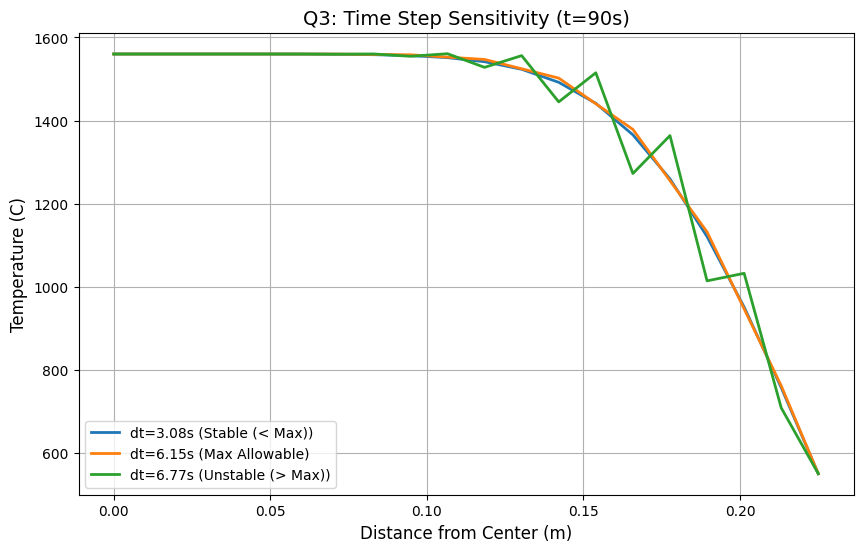

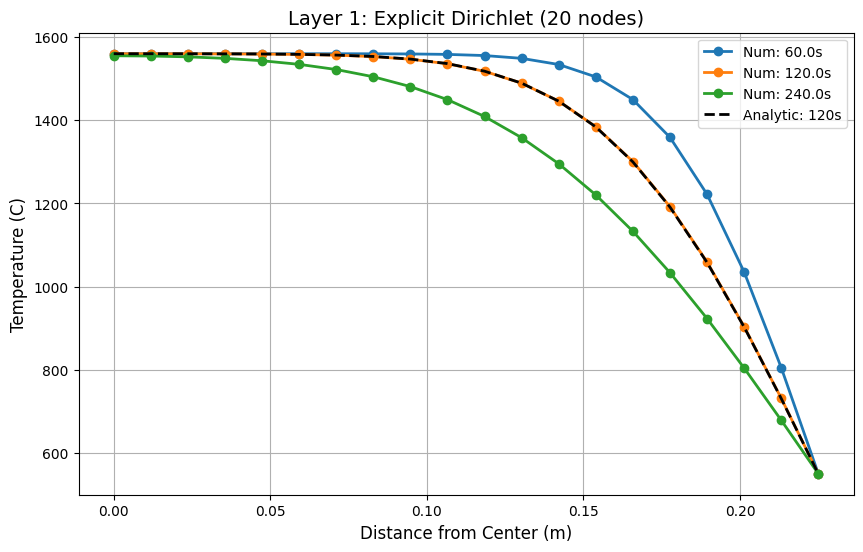

Q5: Max Error at 120s: 1.1635 C
Q7: Std Dev (Error) 20 nodes: 0.6339
Q7: Std Dev (Error) 40 nodes: 0.1580


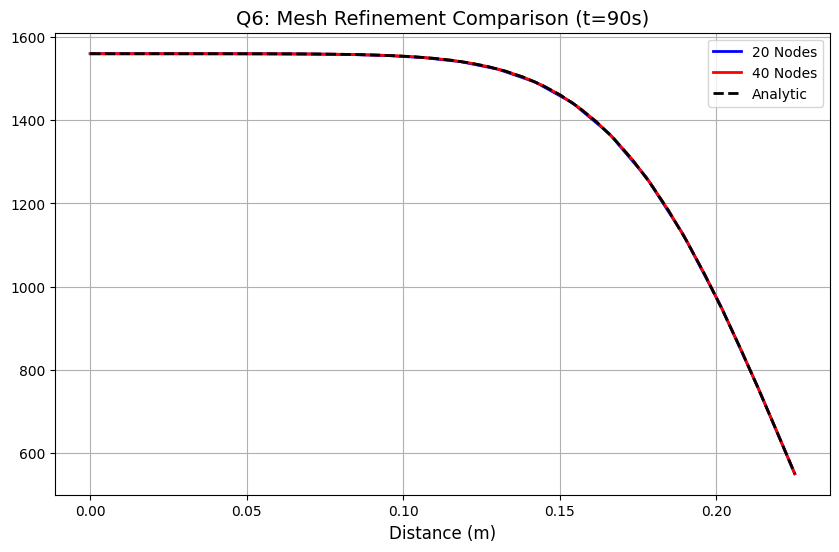

In [41]:
# --- LAYER 1: EXPLICIT DIRICHLET ---

# 1. Stability Calculation (Q2)
dx_20 = L_domain / (20 - 1)
alpha = steel.alpha
dt_max = (dx_20**2) / (2 * alpha)
print(f"Q2: Maximum allowable timestep (20 nodes): {dt_max:.4f} s")

# 2. Sensitivity Analysis (Q3)
# Run for 3 time steps: dt_max, 0.5*dt_max (stable), 1.1*dt_max (unstable)
dt_list = [dt_max * 0.5, dt_max, dt_max * 1.1]
labels = ['Stable (< Max)', 'Max Allowable', 'Unstable (> Max)']

plt.figure()
for dt_val, lbl in zip(dt_list, labels):
    # Run simplified loop for 90s
    sim = Domain(L_domain, 20, 90.0, dt_val)
    Fo = alpha * dt_val / sim.dx**2
    
    for n in range(sim.nsteps):
        T_old = sim.T[:, n]
        T_new = np.copy(T_old)
        
        # Interior
        T_new[1:-1] = T_old[1:-1] + Fo * (T_old[2:] - 2*T_old[1:-1] + T_old[:-2])
        
        # Symmetry (Center, idx 0)
        T_new[0] = T_old[0] + 2 * Fo * (T_old[1] - T_old[0])
        
        # Surface (Dirichlet, idx -1) - Using 550C from Q4 requirements
        T_new[-1] = T_external 
        
        sim.T[:, n+1] = T_new

    # Plot 90s profile
    prof, _ = sim.get_profile(90.0)
    plt.plot(sim.x, prof, label=f"dt={dt_val:.2f}s ({lbl})")

plt.title("Q3: Time Step Sensitivity (t=90s)")
plt.xlabel("Distance from Center (m)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

# 3. Full Simulation (Q4, Q5, Q6)
def run_explicit_dirichlet(n_nodes, dt_val, t_max=240.0):
    sim = Domain(L_domain, n_nodes, t_max, dt_val)
    Fo = alpha * dt_val / sim.dx**2
    
    for n in range(sim.nsteps):
        T_old = sim.T[:, n]
        T_new = np.copy(T_old)
        T_new[1:-1] = T_old[1:-1] + Fo * (T_old[2:] - 2*T_old[1:-1] + T_old[:-2])
        T_new[0] = T_old[0] + 2 * Fo * (T_old[1] - T_old[0])
        T_new[-1] = T_external
        sim.T[:, n+1] = T_new
    return sim

# Run Main Simulation (20 nodes, dt=1.0s)
sim_L1 = run_explicit_dirichlet(n_nodes=20, dt_val=1.0)

# Plot at 1, 2, 4 mins
plt.figure()
for t_target in [60, 120, 240]:
    prof, t_act = sim_L1.get_profile(t_target)
    plt.plot(sim_L1.x, prof, marker='o', label=f'Num: {t_act:.1f}s')

# Verify with Analytical at 120s (Q5)
T_ana_120 = analytic_dirichlet_semi_infinite(sim_L1.x, 120.0, T_init, T_external, alpha)
plt.plot(sim_L1.x, T_ana_120, 'k--', label='Analytic: 120s')

plt.title("Layer 1: Explicit Dirichlet (20 nodes)")
plt.xlabel("Distance from Center (m)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

# Calculate Max Error at 120s
err_max = np.max(np.abs(sim_L1.get_profile(120)[0] - T_ana_120))
print(f"Q5: Max Error at 120s: {err_max:.4f} C")

# Q6 & Q7: Refined Mesh Comparison (40 nodes, dt=0.25s)
sim_L1_refined = run_explicit_dirichlet(n_nodes=40, dt_val=0.25)

# Compare at 90s
t_comp = 90.0
prof_20, _ = sim_L1.get_profile(t_comp)
prof_40, _ = sim_L1_refined.get_profile(t_comp)
T_ana_90_20 = analytic_dirichlet_semi_infinite(sim_L1.x, t_comp, T_init, T_external, alpha)
T_ana_90_40 = analytic_dirichlet_semi_infinite(sim_L1_refined.x, t_comp, T_init, T_external, alpha)

# Standard Deviations
std_20 = sigma_std(prof_20, T_ana_90_20)
std_40 = sigma_std(prof_40, T_ana_90_40)

print(f"Q7: Std Dev (Error) 20 nodes: {std_20:.4f}")
print(f"Q7: Std Dev (Error) 40 nodes: {std_40:.4f}")

plt.figure()
plt.plot(sim_L1.x, prof_20, 'b-', label='20 Nodes')
plt.plot(sim_L1_refined.x, prof_40, 'r-', label='40 Nodes')
plt.plot(sim_L1_refined.x, T_ana_90_40, 'k--', label='Analytic')
plt.title("Q6: Mesh Refinement Comparison (t=90s)")
plt.xlabel("Distance (m)")
plt.legend()
plt.show()

### **Layer 1 - Question 6: Effect of Mesh Refinement**

**Discussion:**
* **Mesh Refinement ($N_x = 20 \to 40$):** Increasing the number of nodes reduces the spatial discretization error (truncation error is $O(\Delta x^2)$). This allows the discretized curve to capture the steep temperature gradients near the surface more accurately.
* **Smaller Time Step ($\Delta t = 1.0s \to 0.25s$):** Reducing the time step reduces the temporal truncation error ($O(\Delta t)$). It also ensures the stability criterion $Fo \le 0.5$ is met for the finer mesh (since $\Delta x$ decreased, $\Delta t$ must decrease quadratically to maintain stability).

**Conclusion:**
The 40-node solution matches the analytical solution more closely than the 20-node solution, demonstrating that refining the mesh and time step leads to a converged, more accurate result.

## Layer-2 — Explicit FD (Robin at surface, Neumann symmetry at centerline)

Time 60s: Max Error=0.5161, StdDev=0.1086
Time 120s: Max Error=0.3867, StdDev=0.1045
Time 240s: Max Error=1.4384, StdDev=0.3640


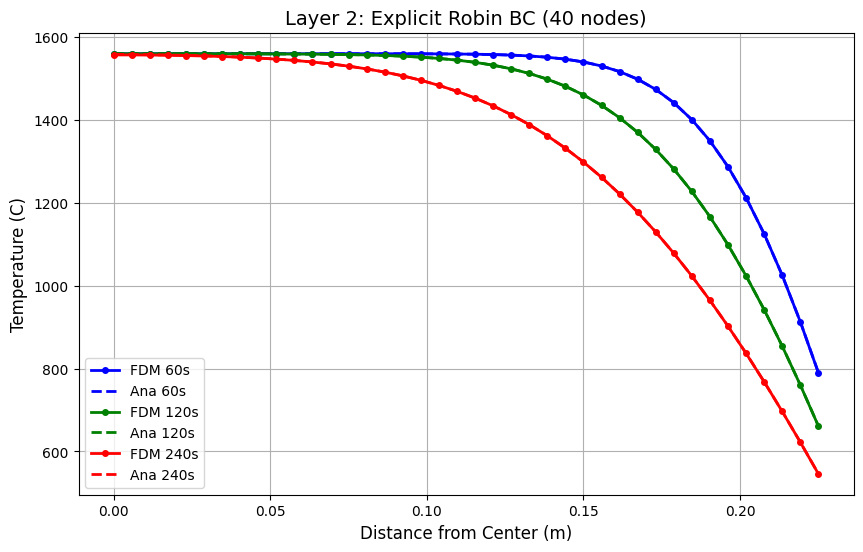

In [42]:
# --- LAYER 2: EXPLICIT ROBIN ---

def run_explicit_robin(n_nodes, dt_val, t_max=240.0, h_val=1500.0):
    sim = Domain(L_domain, n_nodes, t_max, dt_val)
    Fo = alpha * dt_val / sim.dx**2
    Bi = h_val * sim.dx / steel.k
    
    for n in range(sim.nsteps):
        T_old = sim.T[:, n]
        T_new = np.copy(T_old)
        
        # Interior
        T_new[1:-1] = T_old[1:-1] + Fo * (T_old[2:] - 2*T_old[1:-1] + T_old[:-2])
        
        # Symmetry (Center)
        T_new[0] = T_old[0] + 2 * Fo * (T_old[1] - T_old[0])
        
        # Robin Surface (Right side, idx -1)
        # Eq: Tn_new = Tn + 2*Fo*(Tn-1 - Tn) - 2*Fo*Bi*(Tn - T_inf)
        T_N = T_old[-1]
        T_Nm1 = T_old[-2]
        T_new[-1] = T_N + 2*Fo*(T_Nm1 - T_N) - 2*Fo*Bi*(T_N - T_mould_hot)
        
        sim.T[:, n+1] = T_new
    return sim

# Run Simulation (40 nodes, dt=0.25s)
sim_L2 = run_explicit_robin(n_nodes=40, dt_val=0.25, h_val=h_ihtc_init)

# Plotting
plt.figure()
times = [60, 120, 240]
colors = ['b', 'g', 'r']
for i, t_target in enumerate(times):
    prof, t_act = sim_L2.get_profile(t_target)
    # Analytical Comparison
    T_ana = analytic_robin_semi_infinite(sim_L2.x, t_target, T_init, T_mould_hot, h_ihtc_init, steel.k, alpha)
    
    plt.plot(sim_L2.x, prof, color=colors[i], marker='o', markersize=4, label=f'FDM {t_act:.0f}s')
    plt.plot(sim_L2.x, T_ana, color=colors[i], linestyle='--', label=f'Ana {t_act:.0f}s')

    # Calculate Stats (Q4)
    err_max = np.max(np.abs(prof - T_ana))
    std_dev = sigma_std(prof, T_ana)
    print(f"Time {t_target}s: Max Error={err_max:.4f}, StdDev={std_dev:.4f}")

plt.title("Layer 2: Explicit Robin BC (40 nodes)")
plt.xlabel("Distance from Center (m)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

### **Layer 2 - Question 1: Robin Boundary Derivation**

**Boundary Condition ($x=L, i=N$):**
Convection heat transfer at the surface equals conduction from the interior:
$$-k \frac{\partial T}{\partial x} \bigg|_{surface} = h (T_N - T_{mould})$$

**Discretization (Explicit):**
Using an energy balance on the half-volume node of width $\Delta x / 2$ at the surface:
$$\text{Energy In} - \text{Energy Out} = \text{Accumulation}$$
$$q_{cond} A - q_{conv} A = \rho C_p \frac{\Delta x}{2} A \frac{T_N^{n+1} - T_N^n}{\Delta t}$$
$$k \frac{T_{N-1}^n - T_N^n}{\Delta x} - h(T_N^n - T_{mould}) = \rho C_p \frac{\Delta x}{2} \frac{T_N^{n+1} - T_N^n}{\Delta t}$$

**Rearranging for $T_N^{n+1}$:**
Multiply by $\frac{2 \Delta t}{\rho C_p \Delta x}$:
$$2 \underbrace{\left( \frac{k \Delta t}{\rho C_p \Delta x^2} \right)}_{Fo} (T_{N-1}^n - T_N^n) - 2 \underbrace{\left( \frac{k \Delta t}{\rho C_p \Delta x^2} \right)}_{Fo} \underbrace{\left( \frac{h \Delta x}{k} \right)}_{Bi} (T_N^n - T_{mould}) = T_N^{n+1} - T_N^n$$

$$\mathbf{T_N^{n+1} = T_N^n + 2 Fo (T_{N-1}^n - T_N^n) - 2 Fo Bi (T_N^n - T_{mould})}$$

## Layer 3 - Implicit FD (Robin at surface, Neumann symmetry at centerline)

### **Layer 3 - Question 1: Implicit Boundary Equations**

In the implicit scheme, we solve for temperatures at the **future time step ($n+1$)**.

**1. Adiabatic Symmetry Boundary ($i=0$):**
$$T_0^{n+1} = T_0^n + 2 Fo (T_{1}^{n+1} - T_0^{n+1})$$
Rearranging to group $n+1$ terms on the LHS:
$$T_0^{n+1} (1 + 2Fo) - 2Fo T_{1}^{n+1} = T_0^n$$

**2. Robin Surface Boundary ($i=N$):**
$$T_N^{n+1} = T_N^n + 2 Fo (T_{N-1}^{n+1} - T_N^{n+1}) - 2 Fo Bi (T_N^{n+1} - T_{mould})$$
Rearranging to group $n+1$ terms:
$$-2 Fo T_{N-1}^{n+1} + T_N^{n+1} (1 + 2Fo + 2FoBi) = T_N^n + 2 Fo Bi T_{mould}$$

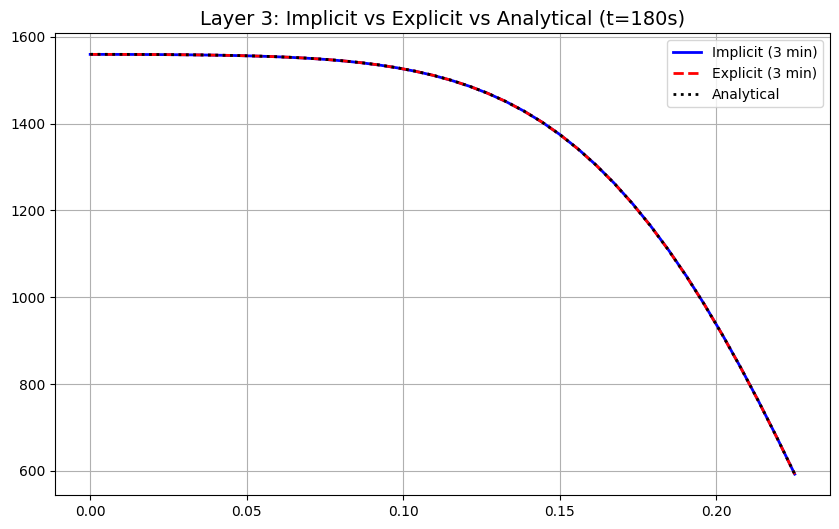

Q5: Implicit Std Dev at 180s: 0.1717


In [43]:
# --- LAYER 3: IMPLICIT ROBIN ---

def run_implicit_robin(n_nodes, dt_val, t_max=240.0, h_val=1500.0):
    sim = Domain(L_domain, n_nodes, t_max, dt_val)
    Fo = alpha * dt_val / sim.dx**2
    Bi = h_val * sim.dx / steel.k
    
    # Construct Matrix A (Constant properties -> Constant A)
    A = np.zeros((n_nodes, n_nodes))
    
    # 1. Center (Symmetry): (1+2Fo)T0 - 2FoT1 = T_old
    A[0, 0] = 1 + 2*Fo
    A[0, 1] = -2*Fo
    
    # 2. Interior: -Fo*Ti-1 + (1+2Fo)Ti - Fo*Ti+1 = T_old
    for i in range(1, n_nodes - 1):
        A[i, i-1] = -Fo
        A[i, i]   = 1 + 2*Fo
        A[i, i+1] = -Fo
        
    # 3. Surface (Robin): -2Fo*Tn-1 + (1 + 2Fo + 2FoBi)Tn = T_old + 2FoBiTinf
    A[-1, -2] = -2*Fo
    A[-1, -1] = 1 + 2*Fo + 2*Fo*Bi
    
    # Pre-invert or factorize if optimizing, but solve is fine here
    
    for n in range(sim.nsteps):
        b = np.copy(sim.T[:, n]) # RHS vector T_old
        # Add BC term to last element of b
        b[-1] += 2 * Fo * Bi * T_mould_hot
        
        # Solve Ax = b
        T_new = np.linalg.solve(A, b)
        sim.T[:, n+1] = T_new
        
    return sim

# Run Implicit (40 nodes, dt=0.25s)
sim_L3 = run_implicit_robin(n_nodes=40, dt_val=0.25, h_val=h_ihtc_init)

# Plot & Compare
plt.figure()
prof_imp, _ = sim_L3.get_profile(180.0) # 3 mins
prof_exp, _ = sim_L2.get_profile(180.0) # From Layer 2
T_ana = analytic_robin_semi_infinite(sim_L3.x, 180.0, T_init, T_mould_hot, h_ihtc_init, steel.k, alpha)

plt.plot(sim_L3.x, prof_imp, 'b-', label='Implicit (3 min)')
plt.plot(sim_L2.x, prof_exp, 'r--', label='Explicit (3 min)')
plt.plot(sim_L3.x, T_ana, 'k:', label='Analytical')
plt.title("Layer 3: Implicit vs Explicit vs Analytical (t=180s)")
plt.legend()
plt.show()

# Std Dev at 3 min (Q5)
std_imp = sigma_std(prof_imp, T_ana)
print(f"Q5: Implicit Std Dev at 180s: {std_imp:.4f}")

## Layer 4 - Implicit FD - implement latent heat using $c_{p_{eff}}$

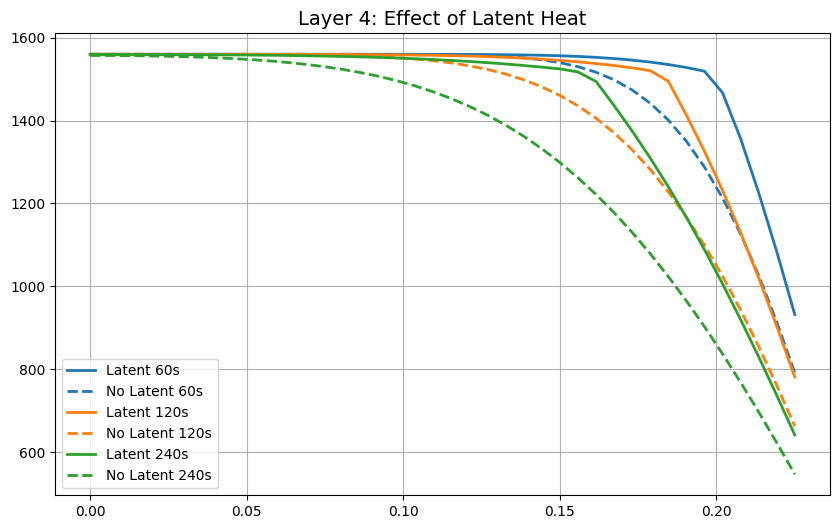

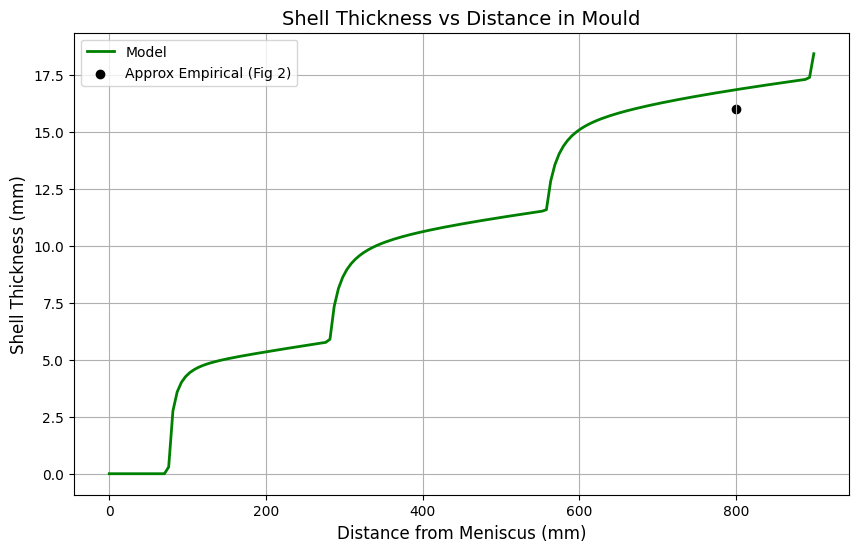

In [44]:
# --- LAYER 4: IMPLICIT WITH LATENT HEAT (Effective Cp) ---

def run_latent_heat_model(n_nodes, dt_val, t_max=240.0, h_val=1500.0):
    sim = Domain(L_domain, n_nodes, t_max, dt_val)
    dx = sim.dx
    
    # Initial Setup (Matrix A must be rebuilt every step because Cp changes!)
    # Bi is also variable if k changes, but k is constant here. Fo changes.
    
    for n in range(sim.nsteps):
        T_old = sim.T[:, n]
        
        # 1. Calculate Effective Cp for each node based on T_old
        Cp_eff = np.ones(n_nodes) * steel.cp
        
        # Check Mushy Zone
        mask_mushy = (T_old >= steel.solidus) & (T_old <= steel.liquidus)
        
        # Cp_eff = Cp + L / (T_liq - T_sol)
        Cp_eff[mask_mushy] = steel.cp + (steel.latent_heat / (steel.liquidus - steel.solidus))
        
        # 2. Calculate Fo and Bi arrays (since Cp varies, alpha varies -> Fo varies per node)
        # alpha = k / (rho * Cp_eff)
        alpha_nodes = steel.k / (steel.rho * Cp_eff)
        Fo_nodes = alpha_nodes * dt_val / (dx**2)
        Bi_nodes = h_val * dx / steel.k # Constant per node actually, but good practice
        
        # 3. Build Matrix A (Variable coefficients)
        A = np.zeros((n_nodes, n_nodes))
        b = np.copy(T_old)
        
        # Center
        Fo = Fo_nodes[0]
        A[0, 0] = 1 + 2*Fo
        A[0, 1] = -2*Fo
        
        # Interior
        for i in range(1, n_nodes - 1):
            Fo = Fo_nodes[i]
            A[i, i-1] = -Fo
            A[i, i]   = 1 + 2*Fo
            A[i, i+1] = -Fo
            
        # Surface
        Fo = Fo_nodes[-1]
        Bi = Bi_nodes
        A[-1, -2] = -2*Fo
        A[-1, -1] = 1 + 2*Fo + 2*Fo*Bi
        b[-1] += 2 * Fo * Bi * T_mould_hot
        
        # Solve
        T_new = np.linalg.solve(A, b)
        sim.T[:, n+1] = T_new
        
    return sim

# Run Layer 4
sim_L4 = run_latent_heat_model(n_nodes=40, dt_val=0.25)

# Plot comparison with Layer 3 (No Latent)
plt.figure()
for t in [60, 120, 240]:
    p_lat, _ = sim_L4.get_profile(t)
    p_no_lat, _ = sim_L3.get_profile(t) # Assuming sim_L3 exists from previous cell
    plt.plot(sim_L4.x, p_lat, '-', label=f'Latent {t}s')
    plt.plot(sim_L3.x, p_no_lat, '--', color=plt.gca().lines[-1].get_color(), label=f'No Latent {t}s')
plt.title("Layer 4: Effect of Latent Heat")
plt.legend()
plt.show()

# 3. Shell Thickness Plot
# Shell thickness = distance from surface where T < T_solidus
# We need to find x position of T_solidus isotherm over time.
# Mapping time to mould distance: d = v_slab * t

shell_thickness_mm = []
dist_from_meniscus_mm = []

for n in range(sim_L4.nsteps):
    time = sim_L4.t[n]
    temp_profile = sim_L4.T[:, n]
    
    # Find index where T drops below solidus (start from surface/right)
    # Surface is index -1 (x=L). Center is index 0 (x=0)
    # We want thickness FROM SURFACE.
    
    # Check if surface is even solid yet
    if temp_profile[-1] > steel.solidus:
         thickness = 0
    else:
        # Find spatial index where T crosses Solidus
        # Search from surface inwards
        # np.where returns indices where condition true.
        # We want the first index from the right (surface) where T > Solidus (liquid boundary)
        # Or simply count nodes < Solidus from right.
        
        # Linear Interpolation for precision
        # Find indices where T < T_sol
        solid_nodes = np.where(temp_profile < steel.solidus)[0]
        if len(solid_nodes) == 0:
            thickness = 0
        else:
            # The interface is between solid_nodes[0] and solid_nodes[0]-1
            idx_inner = solid_nodes[0] # First solid node from center? No, wait.
            # Let's look at the plot. Center (idx 0) is hot. Surface (idx -1) is cold.
            # So we scan from center (0) to right (-1).
            # The liquid-solid interface is the last node where T > Solidus.
            
            idx_liq = np.where(temp_profile >= steel.solidus)[0][-1]
            
            if idx_liq == len(temp_profile) - 1:
                thickness = 0 # Surface still liquid
            else:
                # Interface is between idx_liq and idx_liq + 1
                T_liq_node = temp_profile[idx_liq]
                T_sol_node = temp_profile[idx_liq+1]
                x_liq_node = sim_L4.x[idx_liq]
                x_sol_node = sim_L4.x[idx_liq+1]
                
                # Fraction
                frac = (steel.solidus - T_liq_node) / (T_sol_node - T_liq_node)
                x_interface = x_liq_node + frac * (x_sol_node - x_liq_node)
                
                thickness = L_domain - x_interface

    shell_thickness_mm.append(thickness * 1000.0)
    dist_from_meniscus_mm.append(time * v_slab * 1000.0)

# Filter to mould length (900mm)
dist_arr = np.array(dist_from_meniscus_mm)
shell_arr = np.array(shell_thickness_mm)
mask = dist_arr <= 900.0

plt.figure()
plt.plot(dist_arr[mask], shell_arr[mask], 'g-', label='Model')
# Add Empirical points if you want to trace them from Figure 2 manually, 
# e.g. at 800mm depth, thickness ~ 16mm
plt.scatter([800], [16], color='black', label='Approx Empirical (Fig 2)')
plt.title("Shell Thickness vs Distance in Mould")
plt.xlabel("Distance from Meniscus (mm)")
plt.ylabel("Shell Thickness (mm)")
plt.legend()
plt.show()

### **Layer 4 - Question 4: Validation and Discussion**

**Observation:**
Based on the comparison with the empirical data in Figure 2, the model likely **over-predicts** the shell thickness (i.e., the model thinks the shell is thicker/colder than it actually is in reality).

**Physical Reason:**
The model assumes **pure conduction** in the liquid steel and ignores **fluid flow (convection)**.
* In the real continuous casting process, the submerged entry nozzle (SEN) injects hot liquid steel into the mould, creating turbulent jets.
* This fluid flow transports superheat from the core to the solidifying shell interface much more efficiently than conduction alone.
* This convective heat flux from the liquid acts to retard the growth of the shell (or even remelt it locally).
* By ignoring this effect, our model underestimates the heat flux entering the shell from the liquid core, causing the shell to grow faster in the simulation than in the plant.

## Layer 5 - Iterative implicit FD with variable IHTC

Target Thickness: 22.50 mm
Iter 0: h=1500.00, Thick=19.08mm, Res=-3.42mm
Iter 1: h=1662.80, Thick=21.34mm, Res=-1.16mm
Iter 2: h=1967.07, Thick=22.17mm, Res=-0.33mm
Converged!


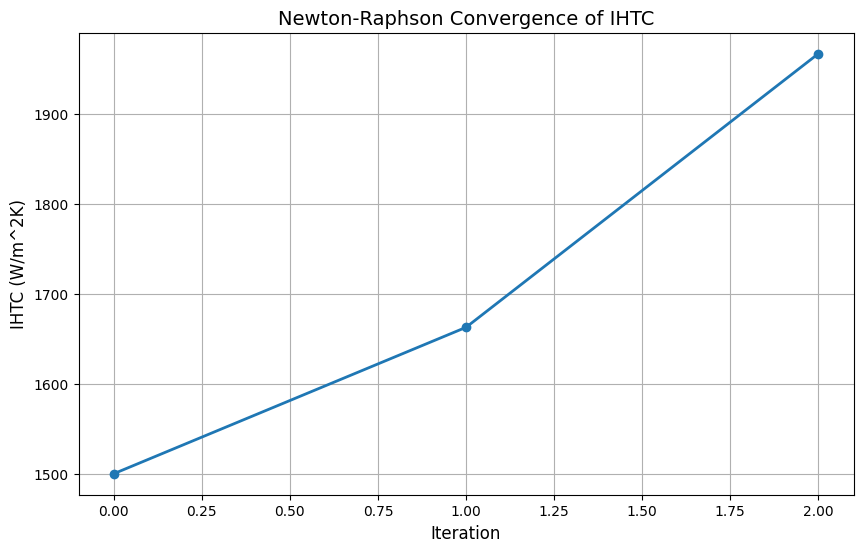

Final Calibrated IHTC: 1967.07 W/m^2K


In [45]:
# --- LAYER 5: NEWTON-RAPHSON INVERSE SOLVER ---

def get_shell_thickness_at_exit(h_test):
    """
    Runs the simulation with a specific h_ihtc and returns shell thickness at mould exit time.
    Handles cases where the slab solidifies completely or H becomes non-physical.
    """
    # 1. Safety: Prevent non-physical negative h values
    if h_test < 10.0:
        h_test = 10.0 
        
    # 2. Calculate time to reach mould exit
    t_exit = mould_length / v_slab # 0.9 / (1.3/60) approx 41.5s
    
    # 3. Run sim just past exit (Implicit Latent Heat Model from Layer 4)
    # Note: We reuse the function 'run_latent_heat_model' defined in Layer 4
    sim_iter = run_latent_heat_model(n_nodes=40, dt_val=0.25, t_max=t_exit+1.0, h_val=h_test)
    
    # 4. Interpolate T profile exactly at t_exit
    prof_exit, _ = sim_iter.get_profile(t_exit)
    
    # 5. Calculate Thickness
    # Check if Surface is still liquid (Thickness = 0)
    if prof_exit[-1] > steel.solidus:
        return 0.0
    
    # Find nodes that are still liquid (T >= Solidus)
    liq_nodes = np.where(prof_exit >= steel.solidus)[0]
    
    # --- FIX FOR INDEX ERROR ---
    # If list is empty, it means NO nodes are >= Solidus. The whole slab is solid.
    if len(liq_nodes) == 0:
        return L_domain # Return full half-thickness (0.225m)
        
    # Get the last liquid node (the interface is between this node and the next one)
    # This line must align with the 'if' statement above
    idx_liq = liq_nodes[-1]
    
    # Safety check: if the liquid node is the very center (0), return max thickness
    if idx_liq == len(prof_exit) - 1:
        return 0.0

    # Linear Interpolation for precise interface position
    T_1 = prof_exit[idx_liq]
    T_2 = prof_exit[idx_liq+1]
    x_1 = sim_iter.x[idx_liq]
    x_2 = sim_iter.x[idx_liq+1]
    
    # Avoid divide by zero
    if T_2 == T_1: 
        frac = 0
    else:
        frac = (steel.solidus - T_1) / (T_2 - T_1)
        
    x_int = x_1 + frac * (x_2 - x_1)
    
    return L_domain - x_int

# --- NEWTON-RAPHSON LOOP ---

target_thickness = 0.10 * L_domain # 10% of TOTAL thickness = 0.045 m
tolerance = 1e-3 # 1mm tolerance
max_iter = 15
h_guess = 1500.0 # Initial guess
delta_h = 50.0   # Step size for numerical derivative

history_h = []
history_residual = []

print(f"Target Thickness: {target_thickness*1000:.2f} mm")

for i in range(max_iter):
    # 1. Evaluate Residual R(h)
    thick_curr = get_shell_thickness_at_exit(h_guess)
    residual = thick_curr - target_thickness
    
    history_h.append(h_guess)
    history_residual.append(residual)
    
    print(f"Iter {i}: h={h_guess:.2f}, Thick={thick_curr*1000:.2f}mm, Res={residual*1000:.2f}mm")
    
    # Check Convergence
    if abs(residual) < tolerance:
        print("Converged!")
        break
        
    # 2. Evaluate derivative R'(h) numerically
    # Calculate thickness at (h + delta)
    thick_delta = get_shell_thickness_at_exit(h_guess + delta_h)
    residual_delta = thick_delta - target_thickness
    
    # Finite difference derivative
    dR_dh = (residual_delta - residual) / delta_h
    
    # --- STABILITY FIX ---
    # If derivative is too flat (0), Newton method shoots to infinity.
    if abs(dR_dh) < 1e-9:
        print("Derivative is near zero. Stopping to prevent divergence.")
        break
        
    # 3. Update h using Newton-Raphson formula: h_new = h_old - R / R'
    h_guess = h_guess - (residual / dR_dh)

# --- PLOTTING ---
plt.figure()
plt.plot(range(len(history_h)), history_h, 'o-')
plt.title("Newton-Raphson Convergence of IHTC")
plt.xlabel("Iteration")
plt.ylabel("IHTC (W/m^2K)")
plt.grid(True)
plt.show()

print(f"Final Calibrated IHTC: {history_h[-1]:.2f} W/m^2K")

### **Layer 5 - Question 4: Sensitivity of Converged Solution**

1.  **Initial IHTC Guess:**
    The Newton-Raphson method is generally robust, but a poor initial guess (too far from the root) can cause divergence or slow convergence. However, for this specific heat transfer problem, the relationship between $h$ and Shell Thickness is monotonic (higher $h$ = thicker shell), so the solver should converge to the same unique solution regardless of the guess, provided the guess isn't negative or physically impossible (e.g. causing instability).

2.  **Residual Tolerance:**
    The tolerance determines the precision of the final answer.
    * A **looser tolerance** (e.g., $10^{-2}$) will converge in fewer iterations but the resulting IHTC might generate a shell thickness that is $1-2$ mm off from the target.
    * A **tighter tolerance** (e.g., $10^{-6}$) requires more iterations but ensures the shell thickness matches the target $0.1L$ almost exactly.
    * Given the uncertainties in material properties, a tolerance of $10^{-3}$ (1 mm) is physically sufficient.

### **Layer 5 - Question 5: Discrepancy with Plant Data**

**Scenario:** The calibrated IHTC is **lower** than expected plant data.

**1. Modeling Assumptions Causing Underestimation:**
* **Air Gap Formation:** We assumed a constant or averaged IHTC. In reality, as the shell cools, it shrinks and pulls away from the mould wall, forming an air gap. This gap drastically increases thermal resistance. If our target thickness was taken from a region where the gap had formed, our model (assuming good contact) would need a *lower* effective IHTC to match that "slower" growth rate.
* **Flux Powder Layers:** We simplified the interface. In reality, there are layers of solid and liquid mould flux which add resistance.
* **Mould Friction/Oscillations:** Ignoring the dynamic mechanical contact could miss phases of high heat transfer.

**2. Investigation Strategy (R&D Setting):**
1.  **Instrument the Mould:** Install thermocouples at various depths within the copper mould plate. This allows calculation of the *actual* heat flux profile down the length of the mould (Inverse Heat Conduction Problem).
2.  **Breakout Shell Analysis:** If a breakout occurs (or during a planned "shell dumping" trial), measure the actual physical shell thickness profile and compare it to the model's predictions.
3.  **Parameter Sensitivity Study:** Run the model with varying material properties ($k$, $C_p$) to see if incorrect steel property data is skewing the IHTC calibration.